## 2D implicit (backward Euler method) with Multi-Grid method as iterative solver

<img src="img/example5.3.1.png">
<img src="img/example5.3.2.png">
<img src="img/example5.3.3.png">
<img src="img/example5.3.4.png">

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange,tnrange

from IPython.display import clear_output
import time

plt.rcParams.update({'font.size': 14})
from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi

from utilities import GS,smoothing, restriction, residual,prolongation


In [83]:
def applyBC(phi, Nx, Ny, S, L, H, convert_to_K=False):
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    ## Right BC
    i = Nx - 1
    for j in range(1, Ny - 1):

        y = j * dy
        phiR = 1000 * (0.25 * np.sinh(0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i, j] = phiR
            S[i, j] = phiR

    ## left BC
    i = 0
    for j in range(1, Ny - 1):

        x = i * dx
        y = j * dy

        phiL = 1000 * (0.25 * np.sinh(-0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i, j] = phiL
            S[i, j] = phiL

            ## Bottom BC
    j = 0
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiB = 1000 * (0.25 * np.sinh(-0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i, j] = phiB
            S[i, j] = phiB

    ## Top BC
    j = Ny - 1
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiT = 1000 * (0.25 * np.sinh(0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i, j] = phiT
            S[i, j] = phiT

    return phi, S


def prepare_phi_and_S(Nx, Ny, L, H, convert_to_K=False):
    # Generate RHS source terms and unknowns 'phi' with Dirichlet BCs
    S = np.zeros((Nx, Ny))
    phi = np.zeros((Nx, Ny))
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy

            source = 1000 * (
                    2 * np.sinh(x - 0.5) + 4 * (x - 0.5) * np.cosh(x - 0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))
            + 1000 * (2 * np.sinh(y - 0.5) + 4 * (y - 0.5) * np.cosh(y - 0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

            S[i, j] = -source

    phi, S = applyBC(phi, Nx, Ny, S, L, H)

    return phi, S
    

# MGM method

In [84]:
# The name of variable ends with c and f are corse and fine mesh
start = time.time()
Nx1 = 41
Ny1 = 41
Nx2 = 21
Ny2 = 21
Nx3 = 11
Ny3 = 11
L = 1  # length
H = 1  # length

phi1 = np.zeros((Nx1, Ny1))
phi2 = np.zeros((Nx2, Ny2))
phi3 = np.zeros((Nx3, Ny3))

dx1 = L / (Nx1 - 1)  # Grid size
dy1 = L / (Ny1 - 1)  # Grid size
x1_list = np.arange(0, 1 + dx1, dx1)
y1_list = np.arange(0, 1 + dy1, dy1)
x1, y1 = np.meshgrid(x1_list, y1_list, indexing='ij')

dx2 = L / (Nx2 - 1)  # Grid size
dy2 = L / (Ny2 - 1)  # Grid size
x2_list = np.arange(0, 1 + dx2, dx2)
y2_list = np.arange(0, 1 + dy2, dy2)
x2, y2 = np.meshgrid(x2_list, y2_list, indexing='ij')

dx3 = L / (Nx3 - 1)  # Grid size
dy3 = L / (Ny3 - 1)  # Grid size
x3_list = np.arange(0, 1 + dx3, dx3)
y3_list = np.arange(0, 1 + dy3, dy3)
x3, y3 = np.meshgrid(x3_list, y3_list, indexing='ij')

tolf = 1e-6

# Define parameters for time advancement
t = 0
alpha = 1
tol = 1e-8
dtmax = (0.5 / alpha) / (1 / dx1 ** 2 + 1 / dy1 ** 2)
dt = 5 * dtmax

# MGM paramters
aE1 = -1 / dx1 ** 2
aW1 = -1 / dx1 ** 2
aN1 = -1 / dy1 ** 2
aS1 = -1 / dy1 ** 2
a01 = (1 / dt + 2 / dx1 ** 2 + 2 / dy1 ** 2)

aE2 = -1 / dx2 ** 2
aW2 = -1 / dx2 ** 2
aN2 = -1 / dy2 ** 2
aS2 = -1 / dy2 ** 2
a02 = (1 / dt + 2 / dx2 ** 2 + 2 / dy2 ** 2)

aE3 = -1 / dx3 ** 2
aW3 = -1 / dx3 ** 2
aN3 = -1 / dy3 ** 2
aS3 = -1 / dy3 ** 2
a03 = (1 / dt + 2 / dx3 ** 2 + 2 / dy3 ** 2)

phi1, RHS = prepare_phi_and_S(Nx1, Ny1, L, H)
total_n = 1000


with tqdm_notebook(range(total_n)) as t:
    for n in t:

        # if n%10==0:
        #     clear_output(True)
        # Progress bar update 
        description = 'Time: ' + str(n*dt)
        t.set_description(desc=description[:14])

        # Source term
        S1 = RHS + phi1 / dt
        R2_1_old, _, _ = residual(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01, convert=False)


        for l in (range(10000)):
            # Smoothing
            R2_1, R_1_new = smoothing(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01)

            # Resitriction on 2nd grid
            phi2, R2_2, R_2_new = restriction(Nx2, Ny2, R_1_new, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list,multi_sweep=10)

            # Resitriction on 3rd grid
            phi3, R2_3, R_3_new = restriction(Nx3, Ny3, R_2_new, aE3, aW3, aE3, aS3, a03, x2_list, y2_list, x3_list, y3_list,multi_sweep=20)

            phi2 = prolongation(x3_list, y3_list, phi3, x2_list, y2_list, phi2)

            phi1 = prolongation(x2_list, y2_list, phi2, x1_list, y1_list, phi1)
            
            if l%100==0:
                print(f'Residual: {R2_1:.7f} @ {n}/{total_n}',end="\r",flush=True)
                
            if R2_1 < tolf:
                
                # print(f'Converged at time step: {n}/{total_n}',end="\r",flush=True)
                break
            
        if l ==0 and R2_1<tolf:
            print(f'Computational time elapsed: {time.time() - start:.2f}')
            break

/var/folders/q9/8vn_nzj55b55_336zczh1y2c0000gp/T/ipykernel_3439/718979073.py:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(range(total_n)) as t:


  0%|          | 0/1000 [00:00<?, ?it/s]

Computational time elapsed: 62.480


## Steady-state solution

In [85]:
# numbering scheme used is k = (j-1)*N + i
start = time.time()
Nx = 41
Ny = 41
L = 1   # length
H = 1   # length


dx = L/(Nx-1)    # Grid size
dy = L/(Ny-1)    # Grid size

tol = 1e-6
aE = 1/dx**2
aW = 1/dx**2
aN = 1/dy**2
aS = 1/dy**2
a0 = -(2/dx**2 + 2/dy**2)

phi, S = prepare_phi_and_S(Nx, Ny, L,H)
S = -S
for _ in tqdm_notebook(range(10000)):

    for i in range(1,Nx-1):
        for j in range(1,Ny-1):

            # Gauss-Siedel Update
            phi[i,j] = (S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1]) / a0

    # Calculate residual
    R2 = 0
    R = np.zeros((Nx,Ny))

    for i in range(1,Nx-1):    
        for j in range(1,Ny-1):
            R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
            R2 = R2+R[i,j]**2

    R2 = np.sqrt(R2)
    if _ %500==0:
        # clear_output(True)/
        print('Residual:', R2,end="\r",flush=True)
        
    if R2<tol:
        print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
        break


/var/folders/q9/8vn_nzj55b55_336zczh1y2c0000gp/T/ipykernel_3439/71076833.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(10000)):


  0%|          | 0/10000 [00:00<?, ?it/s]

Converged! Residual:  9.986470548375556e-07 Time elapsed:  17.13168692588806


### The following analytical solution is given by textbook. The equation in textbook maybe wrong due to either time advancement solver or steady-state solver yields same plot, but they are different from analytical solution

Text(0.5, 1.0, 'Steady Solution')

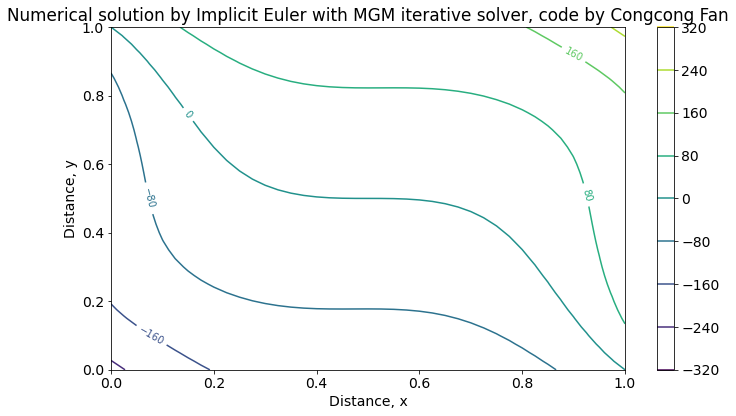

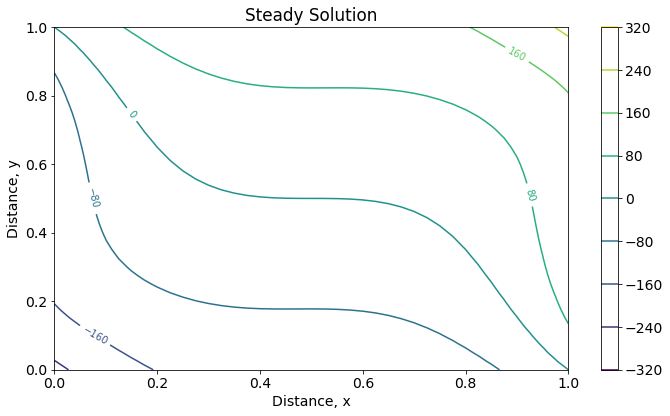

In [86]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = 1000* ( (x[i]-0.5)**2*np.sinh(x[i]-0.5) + (y[j]-0.5)**2 * np.sinh(y[j]-0.5))

plot_phi(phi1, phi, Nx,Ny, 'Implicit Euler with MGM', convert=False)

plt.title('Steady Solution')